In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import dump

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# rating curve

由于枫桥站和苏州站位置接近，同时位于相同水系，我们假定其rating curve（流量-水位曲线）近似，以往均采用拟合的数学公式进行推求。但是相关性分析得出两者相关性只有0.66。这意味两者之间存在着非线性相关性的可能性更大，在这种情况下，我们采用机器学习方法实现这一曲线。

## 随机森林

### Scheme_1: Random forest (Flow — WaterLevel)

Mean Squared Error: 0.05
Root Mean Squared Error: 0.22
Mean Absolute Error: 0.17
R^2 Score: 0.38


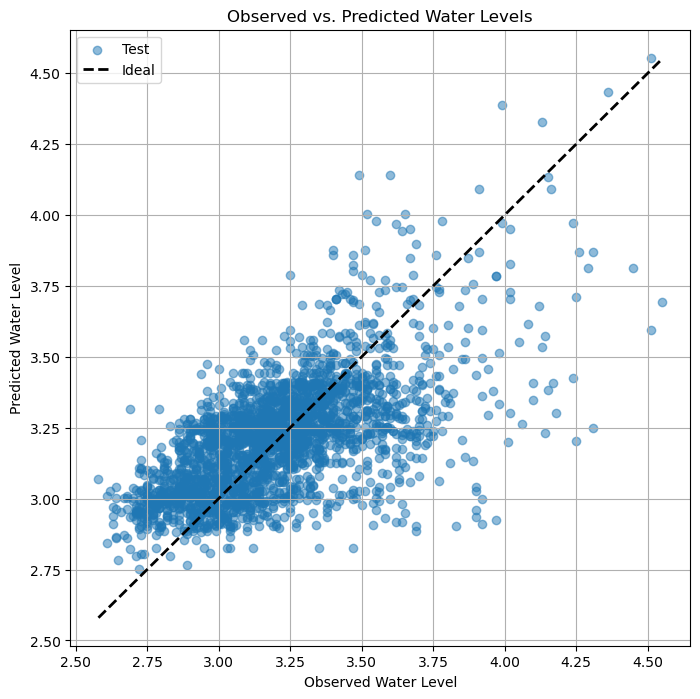

In [22]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv')

# Split data into train and test
X = fengqiao[['discharge']]
y = fengqiao[['water_level']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
y_train = y_train.values.ravel()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='Test', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level')
plt.ylabel('Predicted Water Level')
plt.title('Observed vs. Predicted Water Levels')
plt.legend()  
plt.grid(True)
plt.show()

### Scheme_2: Random forest (Precipitation, Discharge - WaterLevel)

Mean Squared Error: 0.05
Root Mean Squared Error: 0.23
Mean Absolute Error: 0.18
R^2 Score: 0.34


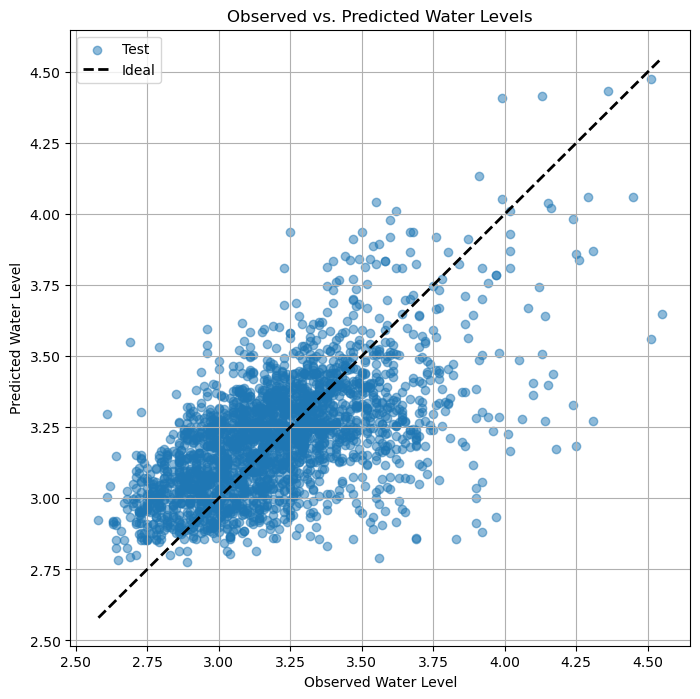

In [18]:
# Split data into train and test
X = fengqiao[['discharge', 'precipitation']]  # Add 'precipitation' as a feature
y = fengqiao[['water_level']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
y_train = y_train.values.ravel()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='Test', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level')
plt.ylabel('Predicted Water Level')
plt.title('Observed vs. Predicted Water Levels')
plt.legend()  
plt.grid(True)
plt.show()

以上两个方案得出的结果都不是很理想，因为我们没有考虑到时间因素，所以我们需要考虑时间因素，我们需要将时间因素加入到我们的模型中。

### Scheme 3: Random forest with time attributes

Mean Squared Error: 0.00
Root Mean Squared Error: 0.06
Mean Absolute Error: 0.04
R^2 Score: 0.95


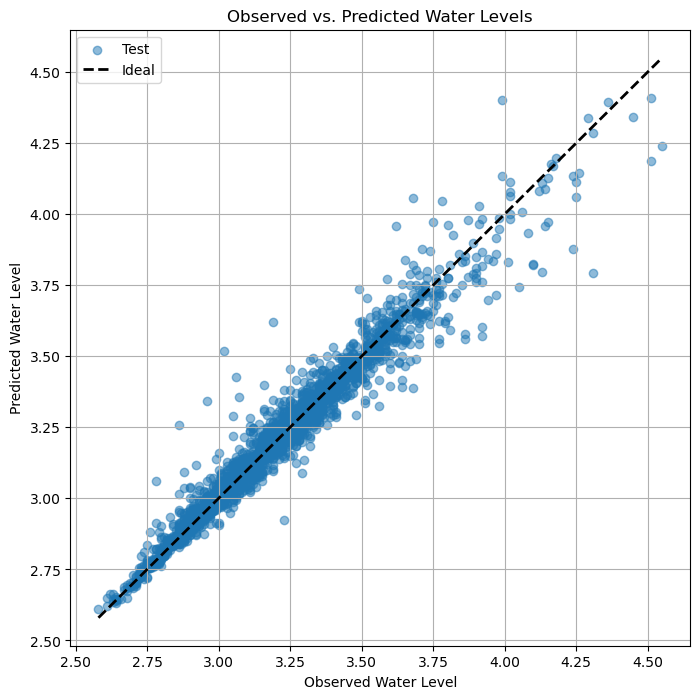

In [80]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
fengqiao['date'] = pd.to_datetime(fengqiao['time'])
fengqiao['days_since_start'] = (fengqiao['date'] - fengqiao['date'].min()).dt.days

# Split data into train and test
X = fengqiao[['discharge', 'days_since_start']]
y = fengqiao[['water_level']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
y_train = y_train.values.ravel()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='Test', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level')
plt.ylabel('Predicted Water Level')
plt.title('Observed vs. Predicted Water Levels')
plt.legend()  
plt.grid(True)
plt.show()


In [81]:
# Get feature importances
importances = model.feature_importances_

# Create a data frame for visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

            Feature  Importance
1  days_since_start    0.510267
0         discharge    0.489733


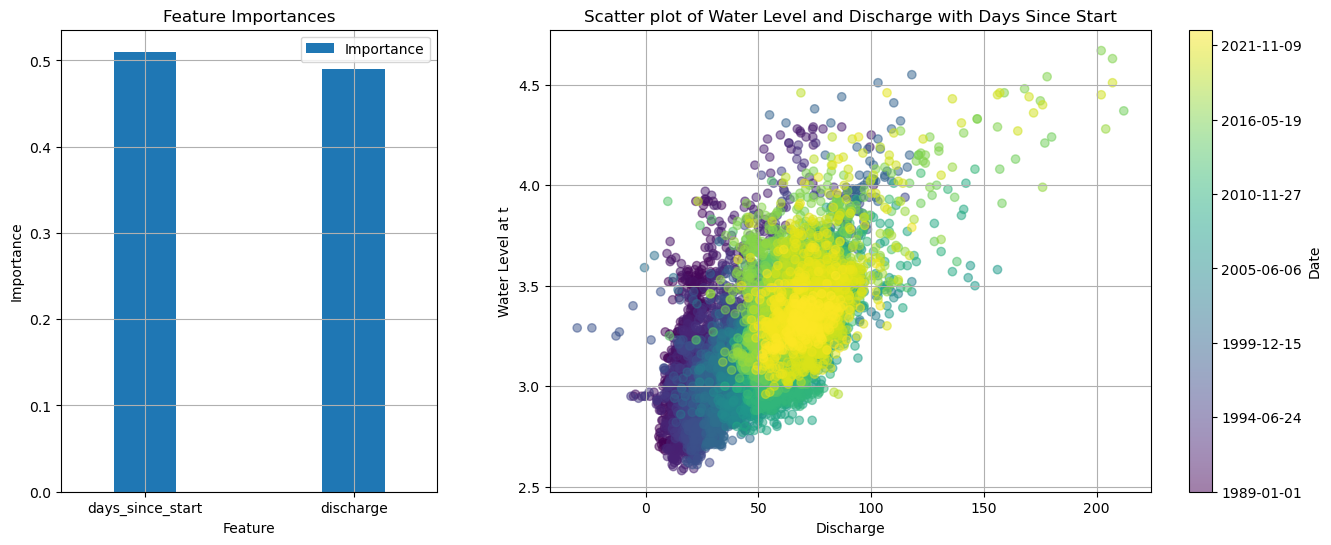

In [121]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a figure with two subplots, with a 1:2 size ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Create a bar plot of feature importances
importances_df.plot.bar(x='Feature', y='Importance', ax=ax1, width=0.3)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Importance')
ax1.set_title('Feature Importances')

# Rotate x-axis labels on the ax1 subplot
for label in ax1.get_xticklabels():
    label.set_rotation(0)  # or use 'horizontal'

ax1.grid(True)

# Create a scatter plot of 'discharge' and 'water_level' with 'days_since_start' as color
scatter = ax2.scatter(fengqiao['discharge'], fengqiao['water_level'], c=fengqiao['days_since_start'], alpha=0.5)

# Create colorbar
colorbar = plt.colorbar(scatter, ax=ax2)

# Get the date that corresponds to the start day
start_date = fengqiao['date'].min()

# Create labels based on 'days_since_start'
colorbar_labels = [start_date + pd.Timedelta(days=int(tick_label)) for tick_label in colorbar.get_ticks()]

# Format labels to the desired string format, for example 'YYYY-MM-DD'
colorbar_labels = [label.strftime('%Y-%m-%d') for label in colorbar_labels]

# Get the ticks
ticks = colorbar.get_ticks()

# Set the ticks
colorbar.ax.yaxis.set_major_locator(plt.FixedLocator(ticks))

# Set new labels
colorbar.ax.set_yticklabels(colorbar_labels)

# Set label for colorbar
colorbar.ax.set_ylabel('Date')

ax2.set_xlabel('Discharge')
ax2.set_ylabel('Water Level at t')
ax2.set_title('Scatter plot of Water Level and Discharge with Days Since Start')
ax2.grid(True)

plt.show()

In [ ]:
# Create a bar plot of feature importances
importances_df.plot.bar(x='Feature', y='Importance', ax=ax1, width=0.3)
ax1.set_xlabel('Feature', rotation=0)
ax1.set_ylabel('Importance')
ax1.set_title('Feature Importances')
ax1.grid(True)

In [124]:
# Get predictions from each tree
y_pred_each_tree = np.array([tree.predict(X_test.values) for tree in model.estimators_])

# Calculate the prediction intervals
lower_bound = np.percentile(y_pred_each_tree, 2.5, axis=0)
upper_bound = np.percentile(y_pred_each_tree, 97.5, axis=0)

print(f"95% prediction interval: {lower_bound} - {upper_bound}")

95% prediction interval: [3.3     3.04    3.08375 ... 2.76    2.88    2.98   ] - [3.45    3.25    3.16575 ... 2.8     3.25    3.17   ]


## Neural Network

### Scheme_4: A simple feedforward neural network

In [32]:
X = fengqiao[['discharge']].values
y = fengqiao[['water_level']].values

# 数据标准化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 将数据转为PyTorch张量
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据加载器
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=10)

# 构建神经网络模型
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
for epoch in range(50):
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 评估模型
with torch.no_grad():
    inputs = X_test
    targets = y_test
    outputs = model(inputs)
    mse = criterion(outputs, targets)
print(f"Mean Squared Error: {mse.item()}")

Mean Squared Error: 0.046260930597782135


把模型放到GPU上

In [38]:
# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = fengqiao[['discharge']].values
y = fengqiao[['water_level']].values

# 数据标准化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 将数据转为PyTorch张量并移到GPU上
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据加载器
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=10)

# 构建神经网络模型并移到GPU上
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
).to(device)

if device.type == 'cuda':
    model = nn.DataParallel(model, device_ids=[0, 1])

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
for epoch in range(50):
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 评估模型
with torch.no_grad():
    inputs = X_test
    targets = y_test
    outputs = model(inputs)
    mse = criterion(outputs, targets)
print(f"Mean Squared Error: {mse.item():.2f}")


Mean Squared Error: 0.05


Mean Squared Error: 0.05
Root Mean Squared Error: 0.21
Mean Absolute Error: 0.16
R^2 Score: 0.44


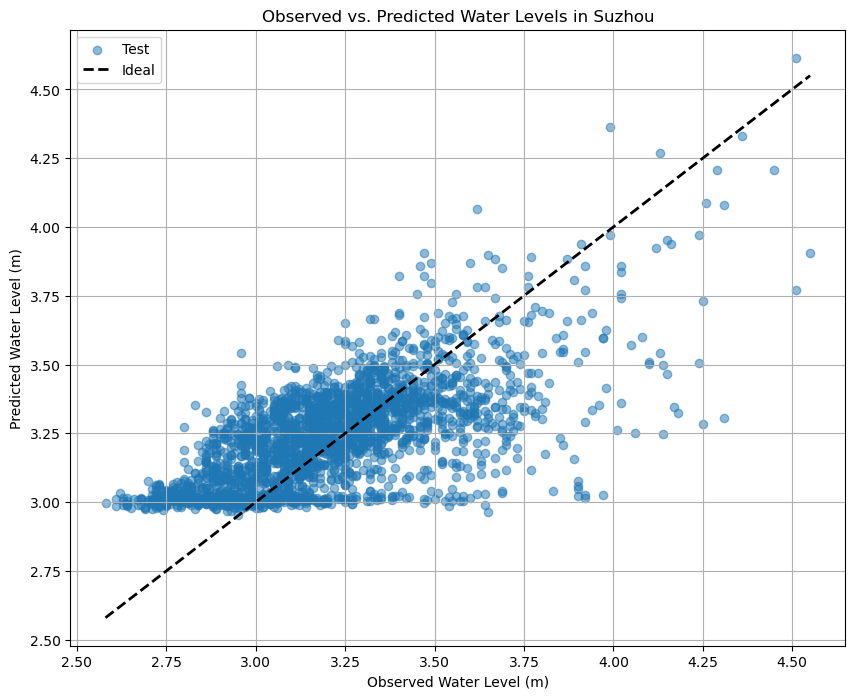

In [40]:
# Evaluate model
mse = mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(targets.cpu().numpy(), outputs.cpu().numpy(), label='Test', alpha=0.5)
plt.plot([targets.cpu().numpy().min(), targets.cpu().numpy().max()], [targets.cpu().numpy().min(), targets.cpu().numpy().max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level (m)')
plt.ylabel('Predicted Water Level (m)')
plt.title('Observed vs. Predicted Water Levels in Suzhou')
plt.legend()  
plt.grid(True)
plt.show()

使用两块GPU训练模型，将你的模型和数据分布到多块GPU上，然后在每个GPU上独立地进行前向和反向传播。结果将被收集并同步。

### Scheme 5: Neural Network with time attributes

Mean Squared Error: 0.04
Root Mean Squared Error: 0.19
Mean Absolute Error: 0.15
R^2 Score: 0.56


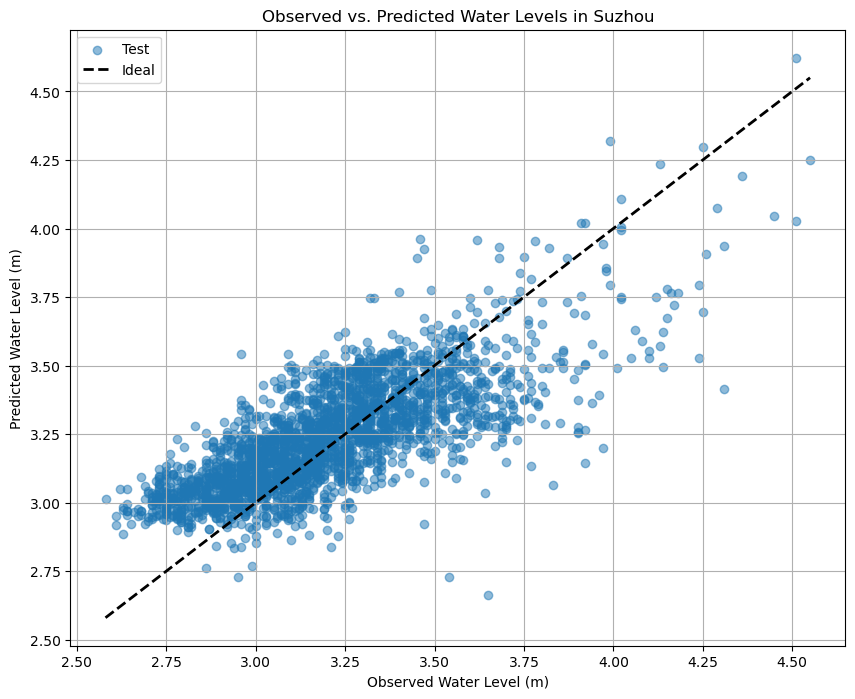

In [46]:
# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
fengqiao['date'] = pd.to_datetime(fengqiao['time'])
fengqiao['days_since_start'] = (fengqiao['date'] - fengqiao['date'].min()).dt.days

# Split data into train and test
X = fengqiao[['discharge', 'days_since_start']].values
y = fengqiao[['water_level']].values

# 数据标准化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 将数据转为PyTorch张量并移到GPU上
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据加载器
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=10)

# 构建神经网络模型并移到GPU上
model = nn.Sequential(
    nn.Linear(2, 32),  # 注意，这里输入的维度变为了2，因为我们现在有两个特征：'discharge'和'days_since_start'
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
).to(device)

if device.type == 'cuda':
    model = nn.DataParallel(model, device_ids=[0, 1])

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
for epoch in range(50):
    for inputs, targets in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 评估模型
with torch.no_grad():
    inputs = X_test
    targets = y_test
    outputs = model(inputs)
    mse = criterion(outputs, targets)

# Evaluate model
mse = mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(targets.cpu().numpy(), outputs.cpu().numpy(), label='Test', alpha=0.5)
plt.plot([targets.cpu().numpy().min(), targets.cpu().numpy().max()], [targets.cpu().numpy().min(), targets.cpu().numpy().max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level (m)')
plt.ylabel('Predicted Water Level (m)')
plt.title('Observed vs. Predicted Water Levels in Suzhou')
plt.legend()  
plt.grid(True)
plt.show()


### Scheme 6 : Neural Network with LSTM

Mean Squared Error: 0.04
Root Mean Squared Error: 0.19
Mean Absolute Error: 0.15
R^2 Score: 0.55


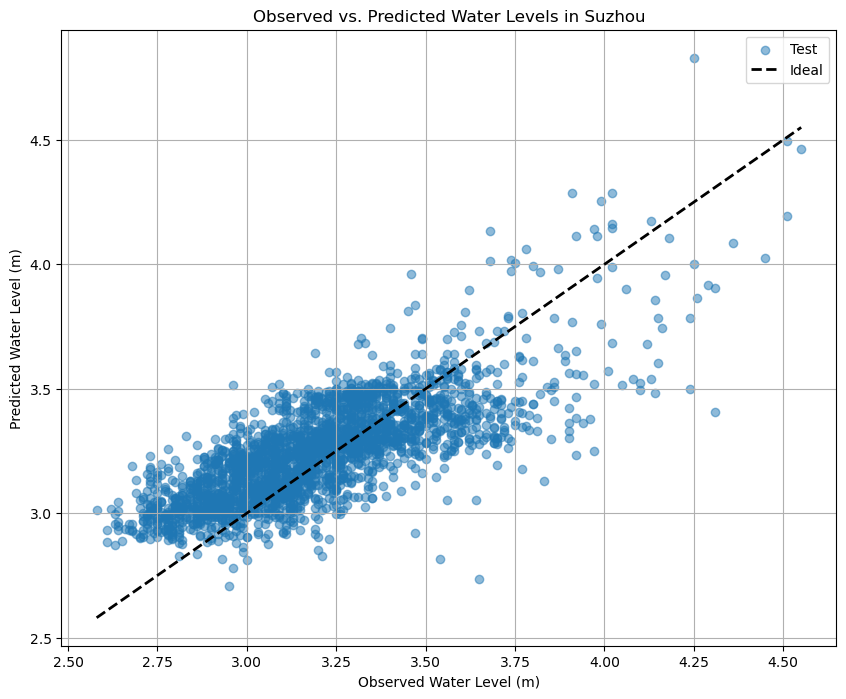

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
fengqiao['date'] = pd.to_datetime(fengqiao['time'])
fengqiao['days_since_start'] = (fengqiao['date'] - fengqiao['date'].min()).dt.days

# Split data into train and test
X = fengqiao[['discharge', 'days_since_start']].values
y = fengqiao[['water_level']].values

# 数据标准化
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 将数据转为PyTorch张量并移到GPU上
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

# reshape input to [samples, time_steps, n_features]
X = X.view(X.shape[0], 1, -1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建数据加载器
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=10)

# 构建LSTM模型
# 构建LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input):
        # Forward pass through LSTM layer
        lstm_out, self.hidden = self.lstm(input.view(len(input), 1, -1))
        
        # Only take the output from the final timestep of each sequence
        # Then pass through a linear layer
        y_pred = self.linear(lstm_out.view(len(input), self.hidden_dim))
        return y_pred.view(-1, 1)  # Changed this line

model = LSTM(2, 32, output_dim=1, num_layers=2)
model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型
for epoch in range(50):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs).view(-1, 1)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 评估模型
with torch.no_grad():
    inputs = X_test
    targets = y_test
    outputs = model(inputs)
    mse = criterion(outputs, targets)

mse = mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(targets.cpu().numpy(), outputs.cpu().numpy())
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(10, 8))
plt.scatter(targets.cpu().numpy(), outputs.cpu().numpy(), label='Test', alpha=0.5)
plt.plot([targets.cpu().numpy().min(), targets.cpu().numpy().max()], [targets.cpu().numpy().min(), targets.cpu().numpy().max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level (m)')
plt.ylabel('Predicted Water Level (m)')
plt.title('Observed vs. Predicted Water Levels in Suzhou')
plt.legend()  
plt.grid(True)
plt.show()

## 时间序列特征

你仍然想用随机森林进行时间序列预测，你可以尝试将一些时间序列特征（如滞后值）添加到你的数据中。以下是一个简单的示例，其中我们创建了一列滞后值作为新的特征。

### Scheme 7: Time lag

Mean Squared Error: 0.00
Root Mean Squared Error: 0.04
Mean Absolute Error: 0.02
R^2 Score: 0.98


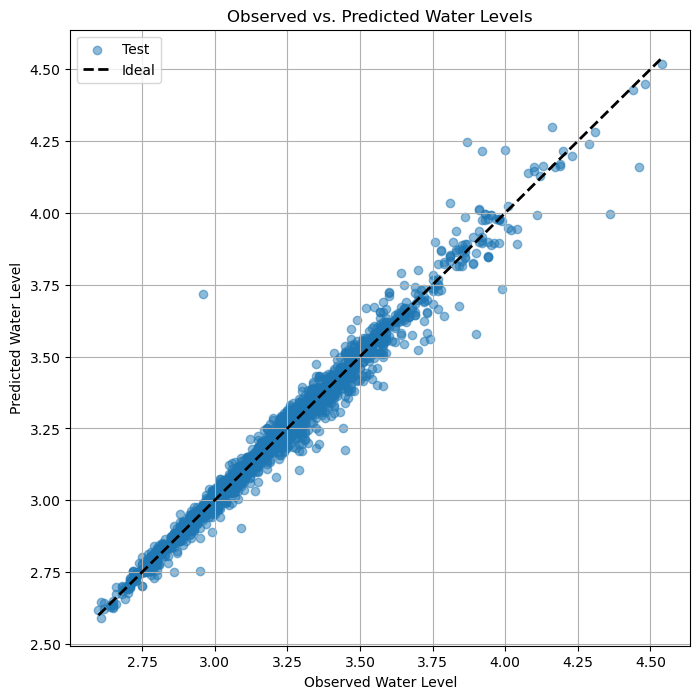

In [63]:
# Import required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
fengqiao = pd.read_csv('../data/intermediate/fengqiao_interpolated.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
fengqiao['date'] = pd.to_datetime(fengqiao['time'])
fengqiao['days_since_start'] = (fengqiao['date'] - fengqiao['date'].min()).dt.days

# Create lag feature
fengqiao['water_level_lag1'] = fengqiao['water_level'].shift(1)

# Drop missing values
fengqiao = fengqiao.dropna()

# Split data into train and test
X = fengqiao[['discharge', 'days_since_start', 'water_level_lag1']]
y = fengqiao['water_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='Test', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Water Level')
plt.ylabel('Predicted Water Level')
plt.title('Observed vs. Predicted Water Levels')
plt.legend()  
plt.grid(True)
plt.show()


In [65]:
# Get feature importances
importances = model.feature_importances_

# Create a data frame for visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

            Feature  Importance
2  water_level_lag1    0.976384
0         discharge    0.013912
1  days_since_start    0.009704


这个特征重要性的结果表明，模型中最重要的特征是 'water_level_lag1'，其重要性远超过了其他特征。这说明在预测水位时，前一时刻的水位值是非常关键的信息。这也很符合我们的直觉，因为在许多物理系统中，现在的状态通常与前一时刻的状态密切相关。

关于通过可视化方式观察滞后特征的影响，你可以使用散点图来展示 'water_level_lag1' 和 'water_level' 之间的关系。这样可以直观地看出两者之间是否存在某种关系。

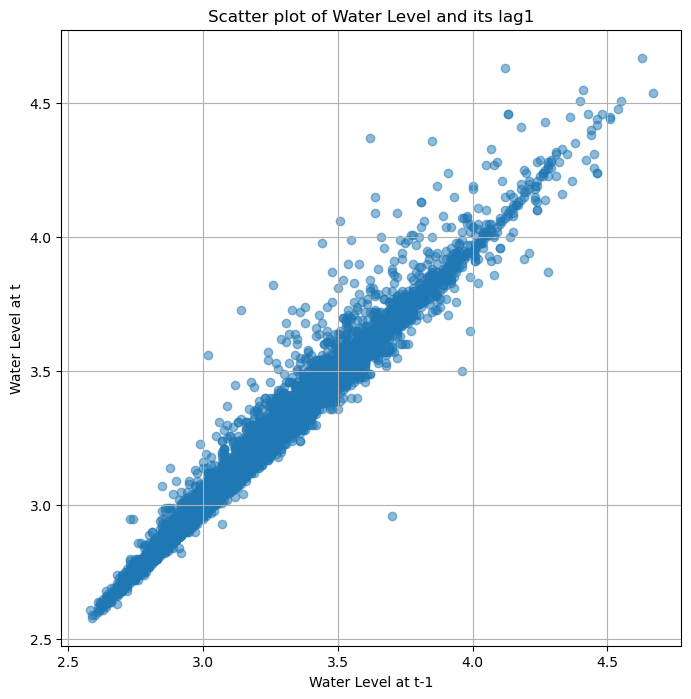

In [66]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Create a scatter plot of 'water_level_lag1' and 'water_level'
plt.figure(figsize=(8, 8))
plt.scatter(fengqiao['water_level_lag1'], fengqiao['water_level'], alpha=0.5)
plt.xlabel('Water Level at t-1')
plt.ylabel('Water Level at t')
plt.title('Scatter plot of Water Level and its lag1')
plt.grid(True)
plt.show()

# 总结

Scheme 3 结果最好，将其保存为最终模型

In [128]:
# Save model to file
dump(model, '../data/intermediate/random_forest_model.joblib')

['../data/intermediate/random_forest_model.joblib']

# Rating curve (water lelvel to discharge)

Mean Squared Error: 42.29
Root Mean Squared Error: 6.50
Mean Absolute Error: 4.11
R^2 Score: 0.92


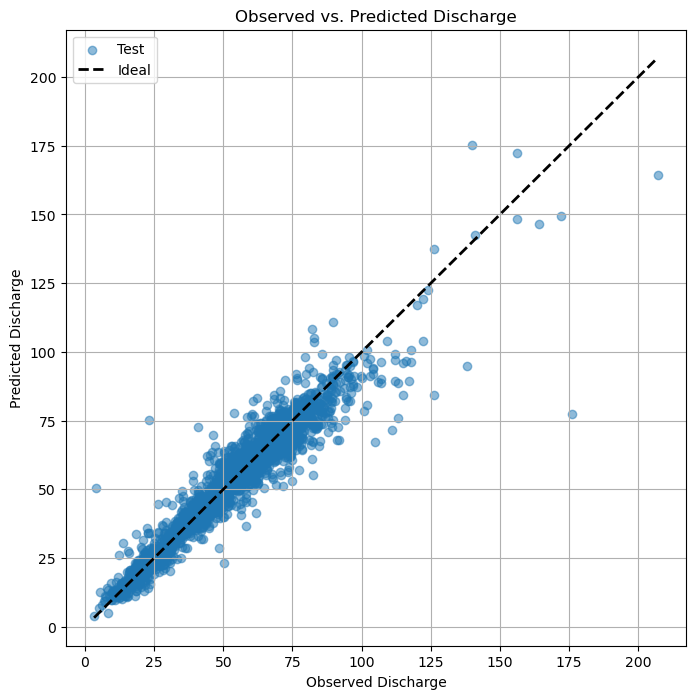

In [13]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_processed.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
fengqiao['date'] = pd.to_datetime(fengqiao['time'])
fengqiao['days_since_start'] = (fengqiao['date'] - fengqiao['date'].min()).dt.days

# Split data into train and test
X = fengqiao[['water_level', 'days_since_start']]
y = fengqiao[['discharge']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
y_train = y_train.values.ravel()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

# Plot results
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, label='Test', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Observed Discharge')
plt.ylabel('Predicted Discharge')
plt.title('Observed vs. Predicted Discharge')
plt.legend()  
plt.grid(True)
plt.show()


In [14]:
# Get feature importances
importances = model.feature_importances_

# Create a data frame for visualization
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

print(importances_df)

            Feature  Importance
1  days_since_start    0.776191
0       water_level    0.223809


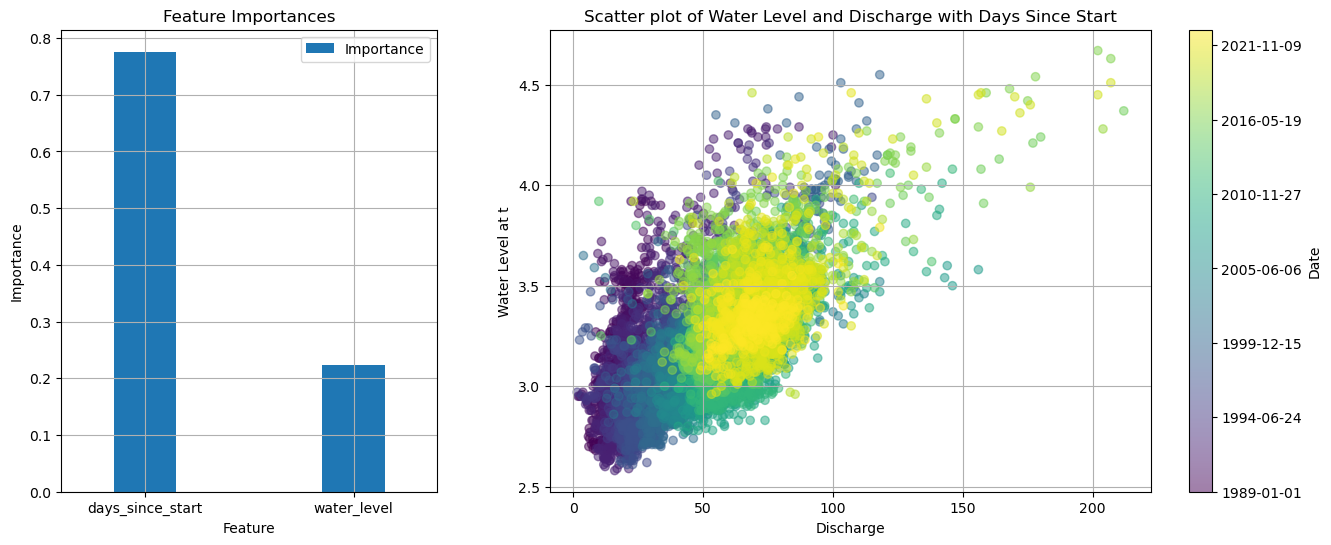

In [15]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Create a figure with two subplots, with a 1:2 size ratio
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Create a bar plot of feature importances
importances_df.plot.bar(x='Feature', y='Importance', ax=ax1, width=0.3)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Importance')
ax1.set_title('Feature Importances')

# Rotate x-axis labels on the ax1 subplot
for label in ax1.get_xticklabels():
    label.set_rotation(0)  # or use 'horizontal'

ax1.grid(True)

# Create a scatter plot of 'discharge' and 'water_level' with 'days_since_start' as color
scatter = ax2.scatter(fengqiao['discharge'], fengqiao['water_level'], c=fengqiao['days_since_start'], alpha=0.5)

# Create colorbar
colorbar = plt.colorbar(scatter, ax=ax2)

# Get the date that corresponds to the start day
start_date = fengqiao['date'].min()

# Create labels based on 'days_since_start'
colorbar_labels = [start_date + pd.Timedelta(days=int(tick_label)) for tick_label in colorbar.get_ticks()]

# Format labels to the desired string format, for example 'YYYY-MM-DD'
colorbar_labels = [label.strftime('%Y-%m-%d') for label in colorbar_labels]

# Get the ticks
ticks = colorbar.get_ticks()

# Set the ticks


colorbar.ax.yaxis.set_major_locator(ticker.FixedLocator(ticks))

# Set new labels
colorbar.ax.set_yticklabels(colorbar_labels)

# Set label for colorbar
colorbar.ax.set_ylabel('Date')

ax2.set_xlabel('Discharge')
ax2.set_ylabel('Water Level at t')
ax2.set_title('Scatter plot of Water Level and Discharge with Days Since Start')
ax2.grid(True)

plt.show()

In [16]:
# Save model to file
dump(model, '../data/intermediate/random_forest_model_w2d.joblib')

['../data/intermediate/random_forest_model_w2d.joblib']

# 神经网络回归 (Neural Network Regression) 

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# 数据预处理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建神经网络模型
model = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=500, random_state=42)

# 训练模型
model.fit(X_train_scaled, y_train)

# 预测
y_pred = model.predict(X_test_scaled)

# 计算指标
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 101.47
Root Mean Squared Error: 10.07
Mean Absolute Error: 7.05
R^2 Score: 0.81


/home/zheng-s/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# 计算苏州的discharge

In [8]:
from joblib import load
import pandas as pd
import numpy as np
suzhou = pd.read_csv('../data/intermediate/suzhou_interpolated.csv')

# Convert the date to datetime format and create a new feature 'days_since_start'
suzhou['date'] = pd.to_datetime(suzhou['time'])
suzhou['days_since_start'] = (suzhou['date'] - suzhou['date'].min()).dt.days

# dump(model, '../data/intermediate/random_forest_model_w2d.joblib')
model = load('../data/intermediate/random_forest_model_w2d.joblib')



suzhou['discharge'] = np.round(model.predict(suzhou[['water_level','days_since_start']]),2)

In [9]:
suzhou.to_csv('../data/intermediate/suzhou_discharge.csv', index=False)